# SEMANTIC ANALYSIS USING AMAZON REVIEWS DATASET

   # IMPORTING LIBRARIES

In [6]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
import matplotlib.pyplot as plt

# DATASET EXPLORATION

In [70]:
# Load the original dataset
df = pd.read_csv('amazon_reviews.csv')


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            4915 non-null   int64  
 1   reviewerName          4914 non-null   object 
 2   overall               4915 non-null   float64
 3   reviewText            4914 non-null   object 
 4   reviewTime            4915 non-null   object 
 5   day_diff              4915 non-null   int64  
 6   helpful_yes           4915 non-null   int64  
 7   helpful_no            4915 non-null   int64  
 8   total_vote            4915 non-null   int64  
 9   score_pos_neg_diff    4915 non-null   int64  
 10  score_average_rating  4915 non-null   float64
 11  wilson_lower_bound    4915 non-null   float64
dtypes: float64(3), int64(6), object(3)
memory usage: 460.9+ KB


In [72]:
df.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0,0.0
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0


In [73]:
df.isnull().sum()

Unnamed: 0              0
reviewerName            1
overall                 0
reviewText              1
reviewTime              0
day_diff                0
helpful_yes             0
helpful_no              0
total_vote              0
score_pos_neg_diff      0
score_average_rating    0
wilson_lower_bound      0
dtype: int64

# PREPROCESSING

In [74]:
# Keep only relevant columns
df = df[['reviewText', 'overall']]


In [75]:
# Preprocess text
stop_words = set(stopwords.words('english'))

In [76]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    # Join tokens back to text
    return ' '.join(tokens)


In [77]:
# Apply preprocessing to reviewText
df['cleaned_reviewText'] = df['reviewText'].apply(lambda x: preprocess_text(x) if pd.notnull(x) else '')


In [78]:
# Replace NaN values with empty strings in the cleaned_reviewText column
df['cleaned_reviewText'] = df['cleaned_reviewText'].fillna('')

In [79]:
# Create sentiment column
def label_sentiment(rating):
    if rating in [1, 2]:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

In [80]:
df['sentiment'] = df['overall'].apply(label_sentiment)

In [81]:
# Save the preprocessed data to a new CSV file
df[['cleaned_reviewText', 'sentiment']].to_csv('preprocessed_amazon_reviews.csv', index=False)

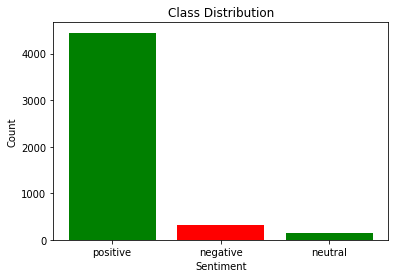

In [85]:
df['sentiment'] = df['overall'].map({1: 'negative', 2: 'negative', 3: 'neutral', 4: 'positive', 5: 'positive'})
sentiment_counts = df['sentiment'].value_counts()
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['green', 'red'])
plt.title('Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# LEXIC AUGMENTATION

In [11]:
# Read negative words from file
with open('negative-words.txt', 'r') as file:
    negative_words = file.read().splitlines()


In [12]:
# Augment the training data with additional negative samples
df_negative_augmented = pd.DataFrame(columns=['cleaned_reviewText', 'sentiment'])
for word in negative_words:
    # Exclude "this product" from negative words
    if "this product" not in word:
        df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)


C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17812\4240530952.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_negative_augmented = df_negative_augmented.append({'cleaned_reviewText': word, 'sentiment': 'negative'}, ignore_index=True)
C:\Users\user\Ap

In [13]:
# Concatenate the original and augmented data
df_augmented = pd.concat([df[['cleaned_reviewText', 'sentiment']], df_negative_augmented])

In [14]:
# Save the augmented data to a new CSV file
df_augmented.to_csv('augmented_amazon_reviews.csv', index=False)

In [7]:
# Load the augmented data
df_augmented = pd.read_csv('augmented_amazon_reviews.csv')


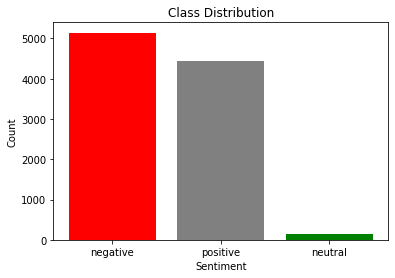

In [8]:
# Visualize class distribution
sentiment_counts = df_augmented['sentiment'].value_counts()
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['red', 'grey', 'green'])
plt.title('Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# DATA PREPARATION

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df_augmented['cleaned_reviewText'],
    df_augmented['sentiment'],
    test_size=0.2,
    random_state=42
)


In [10]:
# Tokenize the text
max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_augmented['cleaned_reviewText'].fillna('').astype(str))  # Replace NaN with empty string
X_train_seq = tokenizer.texts_to_sequences(X_train.fillna('').astype(str))  # Replace NaN with empty string
X_test_seq = tokenizer.texts_to_sequences(X_test.fillna('').astype(str))  # Replace NaN with empty string


In [11]:
# Pad sequences for equal length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)


In [12]:
# Convert sentiment labels to numeric
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)


# 1D CNN --- LSTM --- BIDIRECTIONAL LSTM MODELS

In [14]:
# Build and train the 1D CNN model
model_cnn = Sequential()
model_cnn.add(Embedding(max_words, 64, input_length=max_len))
model_cnn.add(Conv1D(128, 5, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(3, activation='softmax'))
model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_cnn.fit(X_train_pad, y_train_encoded, epochs=10, validation_split=0.2)


Epoch 1/10
195/195 [==============================] - 2s 10ms/step - loss: 0.3289 - accuracy: 0.9260 - val_loss: 0.2050 - val_accuracy: 0.9461
Epoch 2/10
195/195 [==============================] - 2s 9ms/step - loss: 0.1425 - accuracy: 0.9599 - val_loss: 0.1742 - val_accuracy: 0.9557
Epoch 3/10
195/195 [==============================] - 2s 9ms/step - loss: 0.0839 - accuracy: 0.9762 - val_loss: 0.1769 - val_accuracy: 0.9551
Epoch 4/10
195/195 [==============================] - 2s 8ms/step - loss: 0.0493 - accuracy: 0.9838 - val_loss: 0.1935 - val_accuracy: 0.9564
Epoch 5/10
195/195 [==============================] - 2s 8ms/step - loss: 0.0282 - accuracy: 0.9928 - val_loss: 0.2212 - val_accuracy: 0.9519
Epoch 6/10
195/195 [==============================] - 2s 9ms/step - loss: 0.0149 - accuracy: 0.9974 - val_loss: 0.2558 - val_accuracy: 0.9544
Epoch 7/10
195/195 [==============================] - 2s 9ms/step - loss: 0.0087 - accuracy: 0.9989 - val_loss: 0.2761 - val_accuracy: 0.9506
Epoch

In [92]:
# Build and train the LSTM model
model_lstm = Sequential()
model_lstm.add(Embedding(max_words, 64, input_length=max_len))
model_lstm.add(LSTM(128))
model_lstm.add(Dense(3, activation='softmax'))
model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_lstm.fit(X_train_pad, y_train_encoded, epochs=10, validation_split=0.2)



Epoch 1/10
195/195 [==============================] - 12s 53ms/step - loss: 0.2451 - accuracy: 0.9178 - val_loss: 0.1740 - val_accuracy: 0.9461
Epoch 2/10
195/195 [==============================] - 10s 50ms/step - loss: 0.1093 - accuracy: 0.9682 - val_loss: 0.1749 - val_accuracy: 0.9531
Epoch 3/10
195/195 [==============================] - 9s 48ms/step - loss: 0.0732 - accuracy: 0.9777 - val_loss: 0.1957 - val_accuracy: 0.9506
Epoch 4/10
195/195 [==============================] - 9s 47ms/step - loss: 0.0501 - accuracy: 0.9831 - val_loss: 0.2229 - val_accuracy: 0.9416
Epoch 5/10
195/195 [==============================] - 9s 48ms/step - loss: 0.0319 - accuracy: 0.9891 - val_loss: 0.2759 - val_accuracy: 0.9339
Epoch 6/10
195/195 [==============================] - 9s 48ms/step - loss: 0.0283 - accuracy: 0.9926 - val_loss: 0.2727 - val_accuracy: 0.9320
Epoch 7/10
195/195 [==============================] - 9s 47ms/step - loss: 0.0147 - accuracy: 0.9955 - val_loss: 0.2732 - val_accuracy: 0.92

In [93]:
# Build and train the Bidirectional LSTM model
model_bidirectional_lstm = Sequential()
model_bidirectional_lstm.add(Embedding(max_words, 64, input_length=max_len))
model_bidirectional_lstm.add(Bidirectional(LSTM(64)))
model_bidirectional_lstm.add(Dense(3, activation='softmax'))
model_bidirectional_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_bidirectional_lstm.fit(X_train_pad, y_train_encoded, epochs=10, validation_split=0.2)


Epoch 1/10
195/195 [==============================] - 9s 32ms/step - loss: 0.2608 - accuracy: 0.9101 - val_loss: 0.1770 - val_accuracy: 0.9442
Epoch 2/10
195/195 [==============================] - 6s 29ms/step - loss: 0.1186 - accuracy: 0.9656 - val_loss: 0.1693 - val_accuracy: 0.9474
Epoch 3/10
195/195 [==============================] - 6s 29ms/step - loss: 0.0757 - accuracy: 0.9782 - val_loss: 0.1837 - val_accuracy: 0.9512
Epoch 4/10
195/195 [==============================] - 6s 30ms/step - loss: 0.0512 - accuracy: 0.9823 - val_loss: 0.2196 - val_accuracy: 0.9326
Epoch 5/10
195/195 [==============================] - 6s 29ms/step - loss: 0.0379 - accuracy: 0.9886 - val_loss: 0.2486 - val_accuracy: 0.9371
Epoch 6/10
195/195 [==============================] - 6s 30ms/step - loss: 0.0237 - accuracy: 0.9931 - val_loss: 0.2949 - val_accuracy: 0.9307
Epoch 7/10
195/195 [==============================] - 6s 31ms/step - loss: 0.0187 - accuracy: 0.9953 - val_loss: 0.2941 - val_accuracy: 0.9300

# EVALUATION METRICS AND COMPARISON


In [97]:
# Evaluate models
def evaluate_model(model, X_test_pad, y_test_encoded):
    y_pred = np.argmax(model.predict(X_test_pad), axis=1)
    accuracy = np.sum(y_pred == y_test_encoded) / len(y_test_encoded)
    print(classification_report(y_test_encoded, y_pred))
    print(confusion_matrix(y_test_encoded, y_pred))
    return accuracy

In [110]:
print("1D CNN Model Evaluation:")
evaluate_model(model_cnn, X_test_pad, y_test_encoded)

1D CNN Model Evaluation:
61/61 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       991
           1       0.17      0.03      0.06        29
           2       0.95      0.99      0.97       927

    accuracy                           0.97      1947
   macro avg       0.70      0.67      0.67      1947
weighted avg       0.96      0.97      0.96      1947

[[962   3  26]
 [  6   1  22]
 [  7   2 918]]


0.9661016949152542

In [111]:
print("\nLSTM Model Evaluation:")
evaluate_model(model_lstm, X_test_pad, y_test_encoded)


LSTM Model Evaluation:
61/61 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       991
           1       0.13      0.14      0.13        29
           2       0.93      0.97      0.95       927

    accuracy                           0.95      1947
   macro avg       0.68      0.69      0.68      1947
weighted avg       0.95      0.95      0.95      1947

[[941  10  40]
 [  1   4  24]
 [  9  17 901]]


0.9481253210066769

In [112]:
print("\nBidirectional LSTM Model Evaluation:")
evaluate_model(model_bidirectional_lstm, X_test_pad, y_test_encoded)


Bidirectional LSTM Model Evaluation:
61/61 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       991
           1       0.04      0.07      0.05        29
           2       0.93      0.97      0.95       927

    accuracy                           0.94      1947
   macro avg       0.65      0.66      0.65      1947
weighted avg       0.95      0.94      0.94      1947

[[928  19  44]
 [  1   2  26]
 [  6  24 897]]


0.938366718027735

In [113]:
# Evaluate models
accuracy_cnn = evaluate_model(model_cnn, X_test_pad, y_test_encoded)
accuracy_lstm = evaluate_model(model_lstm, X_test_pad, y_test_encoded)
accuracy_bidirectional_lstm = evaluate_model(model_bidirectional_lstm, X_test_pad, y_test_encoded)

61/61 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       991
           1       0.17      0.03      0.06        29
           2       0.95      0.99      0.97       927

    accuracy                           0.97      1947
   macro avg       0.70      0.67      0.67      1947
weighted avg       0.96      0.97      0.96      1947

[[962   3  26]
 [  6   1  22]
 [  7   2 918]]
61/61 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       991
           1       0.13      0.14      0.13        29
           2       0.93      0.97      0.95       927

    accuracy                           0.95      1947
   macro avg       0.68      0.69      0.68      1947
weighted avg       0.95      0.95      0.95      1947

[[941  10  40]
 [  1   4  24]
 [  9  17 901]]
61/61 [==============================] 

In [101]:
best_model = max([
    ("1D CNN", accuracy_cnn),
    ("LSTM", accuracy_lstm),
    ("Bidirectional LSTM", accuracy_bidirectional_lstm)
], key=lambda x: x[1])

In [102]:
print(f"\nThe best model is {best_model[0]} with an accuracy of {best_model[1]:.2%}.")


The best model is 1D CNN with an accuracy of 96.61%.


# CNN MODEL TESTING

In [13]:
custom_comment = " this product is good and works great"
custom_comment_seq = tokenizer.texts_to_sequences([custom_comment])
custom_comment_pad = pad_sequences(custom_comment_seq, maxlen=max_len)
prediction = model_cnn.predict(custom_comment_pad)


NameError: name 'model_cnn' is not defined

In [ ]:
predicted_sentiment = le.classes_[np.argmax(prediction)]
print(f'Predicted Sentiment: {predicted_sentiment}')